In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf 


In [ ]:
import PIL
print(PIL.__version__)

8.2.0


In [ ]:
# Si pillow == 8.3.0 hacer un downgrade para no tener
# TypeError: __array__() takes 1 positional argument but 2 were given (Image classification Keras)
!pip install pillow==8.2.0

You should consider upgrading via the 'C:\Users\zek\Envs\emotion\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
# Vemos si la GPU esta activada

physical_devices = tf.config.list_physical_devices('GPU')
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print("Num GPUs:", len(physical_devices))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:07:00.0, compute capability: 6.1

Num GPUs: 1


In [ ]:
# Cargamos las carpetas de train y test en las variables

train_dir = 'train'
val_dir = 'test'

In [ ]:
# Ver cuantas clases de emociones hay

emociones = os.listdir(train_dir)
print("Cantidad de tipos de emociones:", len(emociones))

Cantidad de tipos de emociones: 7


In [ ]:
# Ver que clases de emociones existen

os.listdir(train_dir)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

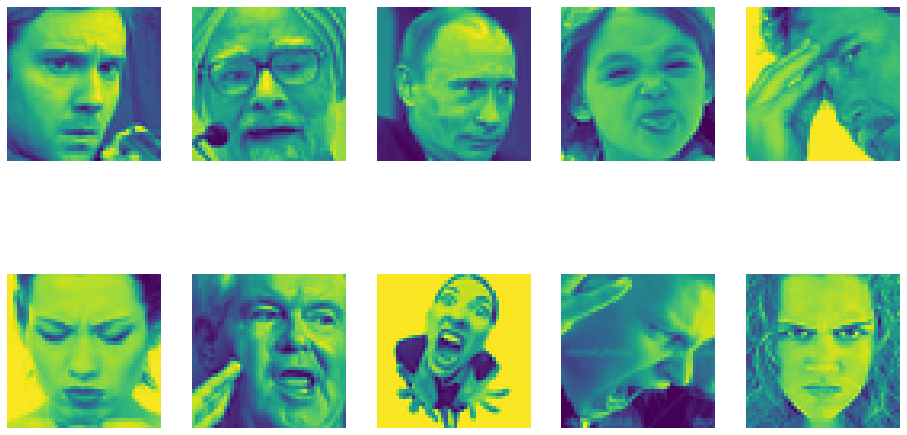

In [ ]:
# Visualizar las 10 primeras imagenes de emociones

files = glob(train_dir + "/" + emociones[0] + "/**.png")

fig = plt.figure(figsize=(16,9))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.axis('off')
    img = mpimg.imread(files[i])
    plt.imshow(img)
    
plt.show()

In [ ]:
# Visualizar la dimension de la primera imagen

img = mpimg.imread(files[0])
img.shape

(48, 48)

In [ ]:
# Visualizar como están representados los pixeles (0 a 1)

print(img[30, 15:30])

[0.654902   0.654902   0.63529414 0.59607846 0.5254902  0.4509804
 0.49411765 0.46666667 0.41568628 0.3882353  0.42745098 0.5529412
 0.61960787 0.5882353  0.60784316]


[('angry', 3995), ('disgusted', 436), ('fearful', 4097), ('happy', 7215), ('neutral', 4965), ('sad', 4830), ('surprised', 3171)]


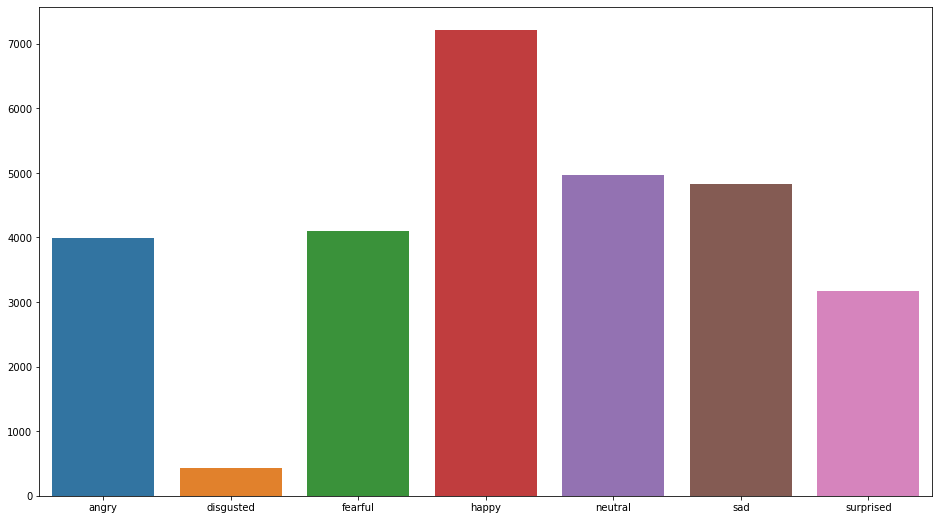

In [ ]:
# Analizar cuantas emociones hay de cada una

nombre_emociones = []
cantidad_emociones = []
for emocion in emociones:
    nombre_emocion = emocion.split("_")[0]
    files = glob(train_dir + "/" + emocion + "/**.png")
    nombre_emociones.append(nombre_emocion)
    cantidad_emociones.append(len(files))

emociones = zip(nombre_emociones, cantidad_emociones)
zipped_list = list(emociones)

print(zipped_list)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
sns.barplot(x=nombre_emociones, y=cantidad_emociones, ax=ax)
plt.show()

In [ ]:
# Creamos generadores, train y test

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
batch_imagenes, batch_clases = train_generator.next()

In [ ]:
batch_imagenes.shape

(64, 48, 48, 1)

In [ ]:
batch_clases.shape

(64, 7)

In [ ]:
print("Cantidad de imagenes en el batch:", batch_imagenes.shape[0])
print("Dimensión de la imagen:", batch_imagenes.shape[1:])

Cantidad de imagenes en el batch: 64
Dimensión de la imagen: (48, 48, 1)


In [ ]:
print("Cantidad de clases/emociones:", batch_clases.shape[1])

Cantidad de clases/emociones: 7


In [ ]:
steps_per_epoch_train = len(train_generator)
steps_per_epoch_train

449

In [ ]:
steps_per_epoch_validation = len(validation_generator)
steps_per_epoch_validation

113

In [ ]:
in_shape = (48, 48, 1)
in_shape

(48, 48, 1)

In [ ]:
out_shape = 7
out_shape

7

In [ ]:
model = Sequential()



model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(out_shape, activation="softmax"))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_72 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_73 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 24, 24, 64)      

In [ ]:
# Compilamos el modelo

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

emocion_model_info = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch_train,
        epochs=200,
        validation_data=validation_generator,
        validation_steps=steps_per_epoch_validation)

Epoch 1/200
449/449 [==============================] - 13s 27ms/step - loss: 2.7486 - accuracy: 0.1870 - val_loss: 2.4269 - val_accuracy: 0.1219
Epoch 2/200
449/449 [==============================] - 12s 27ms/step - loss: 2.2990 - accuracy: 0.2313 - val_loss: 1.9377 - val_accuracy: 0.2318
Epoch 3/200
449/449 [==============================] - 12s 27ms/step - loss: 2.1194 - accuracy: 0.2623 - val_loss: 1.8293 - val_accuracy: 0.2986
Epoch 4/200
449/449 [==============================] - 12s 27ms/step - loss: 2.0046 - accuracy: 0.2935 - val_loss: 1.6961 - val_accuracy: 0.3562
Epoch 5/200
449/449 [==============================] - 12s 27ms/step - loss: 1.8948 - accuracy: 0.3243 - val_loss: 1.6433 - val_accuracy: 0.3780
Epoch 6/200
449/449 [==============================] - 12s 27ms/step - loss: 1.8119 - accuracy: 0.3408 - val_loss: 1.5989 - val_accuracy: 0.3835
Epoch 7/200
449/449 [==============================] - 12s 27ms/step - loss: 1.7353 - accuracy: 0.3670 - val_loss: 1.5392 - val_ac

449/449 [==============================] - 12s 27ms/step - loss: 0.9262 - accuracy: 0.6543 - val_loss: 0.9866 - val_accuracy: 0.6390
Epoch 58/200
449/449 [==============================] - 12s 27ms/step - loss: 0.9215 - accuracy: 0.6551 - val_loss: 0.9892 - val_accuracy: 0.6335
Epoch 59/200
449/449 [==============================] - 12s 27ms/step - loss: 0.9060 - accuracy: 0.6635 - val_loss: 0.9875 - val_accuracy: 0.6350
Epoch 60/200
449/449 [==============================] - 12s 27ms/step - loss: 0.9093 - accuracy: 0.6591 - val_loss: 1.0047 - val_accuracy: 0.6312
Epoch 61/200
449/449 [==============================] - 12s 27ms/step - loss: 0.8998 - accuracy: 0.6677 - val_loss: 0.9821 - val_accuracy: 0.6414
Epoch 62/200
449/449 [==============================] - 12s 27ms/step - loss: 0.8972 - accuracy: 0.6615 - val_loss: 0.9835 - val_accuracy: 0.6450
Epoch 63/200
449/449 [==============================] - 12s 27ms/step - loss: 0.8962 - accuracy: 0.6657 - val_loss: 0.9851 - val_accuracy

449/449 [==============================] - 12s 27ms/step - loss: 0.7024 - accuracy: 0.7415 - val_loss: 0.9805 - val_accuracy: 0.6602
Epoch 114/200
449/449 [==============================] - 12s 27ms/step - loss: 0.7020 - accuracy: 0.7381 - val_loss: 0.9878 - val_accuracy: 0.6567
Epoch 115/200
449/449 [==============================] - 12s 27ms/step - loss: 0.6938 - accuracy: 0.7403 - val_loss: 0.9794 - val_accuracy: 0.6587
Epoch 116/200
449/449 [==============================] - 12s 27ms/step - loss: 0.6940 - accuracy: 0.7438 - val_loss: 0.9797 - val_accuracy: 0.6590
Epoch 117/200
449/449 [==============================] - 12s 27ms/step - loss: 0.6964 - accuracy: 0.7400 - val_loss: 0.9757 - val_accuracy: 0.6581
Epoch 118/200
449/449 [==============================] - 12s 27ms/step - loss: 0.6916 - accuracy: 0.7400 - val_loss: 0.9724 - val_accuracy: 0.6573
Epoch 119/200
449/449 [==============================] - 12s 27ms/step - loss: 0.6826 - accuracy: 0.7470 - val_loss: 0.9942 - val_ac

449/449 [==============================] - 12s 27ms/step - loss: 0.5847 - accuracy: 0.7842 - val_loss: 1.0098 - val_accuracy: 0.6609
Epoch 169/200
449/449 [==============================] - 12s 27ms/step - loss: 0.5750 - accuracy: 0.7892 - val_loss: 1.0203 - val_accuracy: 0.6629
Epoch 170/200
449/449 [==============================] - 12s 27ms/step - loss: 0.5688 - accuracy: 0.7896 - val_loss: 1.0101 - val_accuracy: 0.6679
Epoch 171/200
449/449 [==============================] - 12s 27ms/step - loss: 0.5719 - accuracy: 0.7874 - val_loss: 1.0076 - val_accuracy: 0.6634
Epoch 172/200
449/449 [==============================] - 12s 27ms/step - loss: 0.5723 - accuracy: 0.7860 - val_loss: 1.0163 - val_accuracy: 0.6643
Epoch 173/200
449/449 [==============================] - 12s 27ms/step - loss: 0.5695 - accuracy: 0.7888 - val_loss: 1.0072 - val_accuracy: 0.6649
Epoch 174/200
449/449 [==============================] - 12s 27ms/step - loss: 0.5718 - accuracy: 0.7874 - val_loss: 1.0127 - val_ac

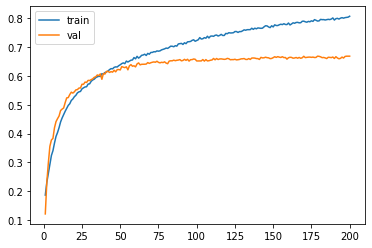

In [ ]:
epoch_count = range(1, len(emocion_model_info.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=emocion_model_info.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=emocion_model_info.history['val_accuracy'], label='val')
plt.show()

In [ ]:
# Guardamos el modelo

emocion_model.save('emocion_model.h5')

In [ ]:
# Cargamos el modelo

from tensorflow.keras import models
emocion_model = models.load_model('emocion_model.h5')

In [ ]:
def emocion(emotions):
    x = ('Enojado', 'Disgustado', 'Miedoso', 'Feliz', 'Neutro', 'Triste', 'Sorprendido' )
    y = np.arange(len(x))
    
    plt.subplots(figsize=(9, 4))
    plt.bar(y, emotions, align='center', alpha=0.5)
    plt.xticks(y, x)
    plt.ylabel('Porcentaje')
    plt.title('Sentimientos')
    
    plt.show()

In [ ]:
import cv2
            
def cara(image):  
    facedata = 'haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for face in faces:
            x, y, w, h = [ v for v in face ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]
            
            cv2.imwrite('cara_cortada.jpg', sub_face)
           

    except Exception as e:
        print (e)


name 'font' is not defined


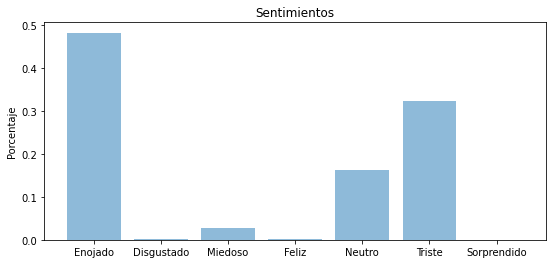

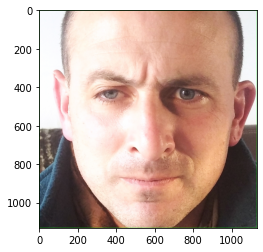

In [ ]:
if __name__ == '__main__':
    cara('leo.jpg')


file = 'cara_cortada.jpg'
imagen_cortada = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

emotions = emocion_model.predict(x)
emocion(emotions[0])

plt.imshow(imagen_cortada)
plt.show()